In [33]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image


import matplotlib.image as img
from scipy.stats import mode
import datetime
%matplotlib inline

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})
df = pd.read_csv('files/train.csv', sep= ',')
DATA_TRAIN_PATH = 'files/train.csv'
data=pd.read_csv(DATA_TRAIN_PATH)
DATA_TEST_PATH='test.csv'
X_test=pd.read_csv(DATA_TEST_PATH)

#DATASET_PATH = './housing.csv'
PREPARED_DATASET_PATH = './price_prepared.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [34]:
#Преобразуем DistrictId и ID в тип object
df.DistrictId=df.DistrictId.astype('object')
df.Id=df.Id.astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

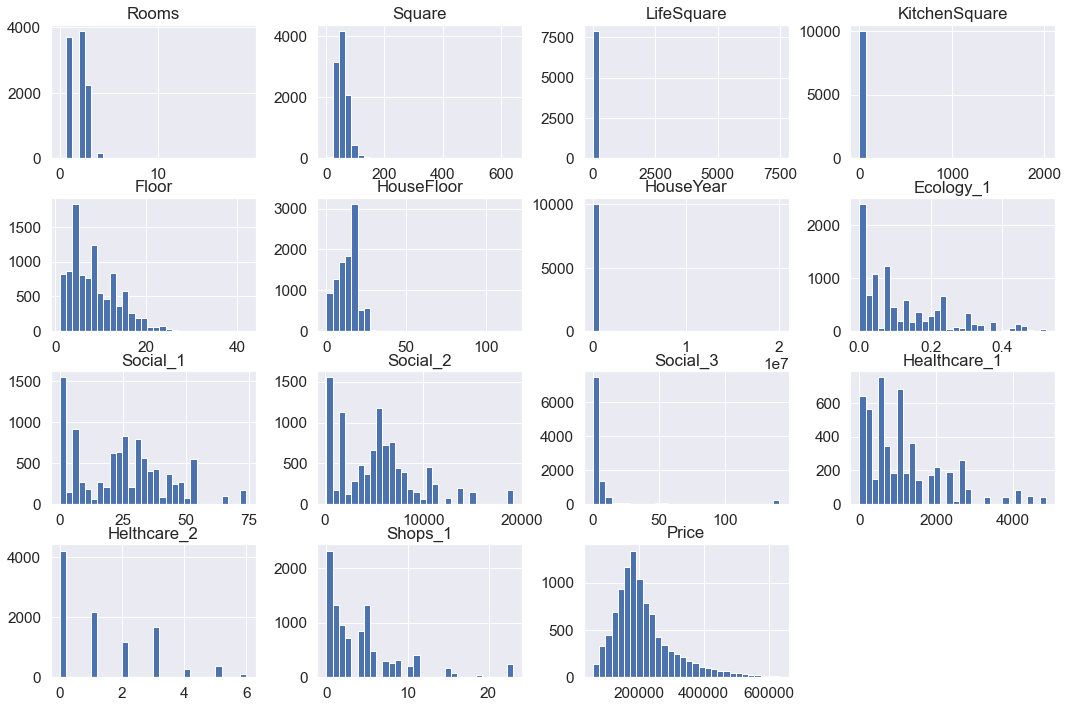

In [35]:
digital_features=df.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(18,12), bins=30)
plt.show()

In [36]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [37]:
# посмотрим описательные статистики
# аномальные минимальные и максимальные значения у признаков Rooms, Square, LifeSquare, KitchenSquare
# также видны пропуски для признаков LifeSquare и Healthcare_1
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


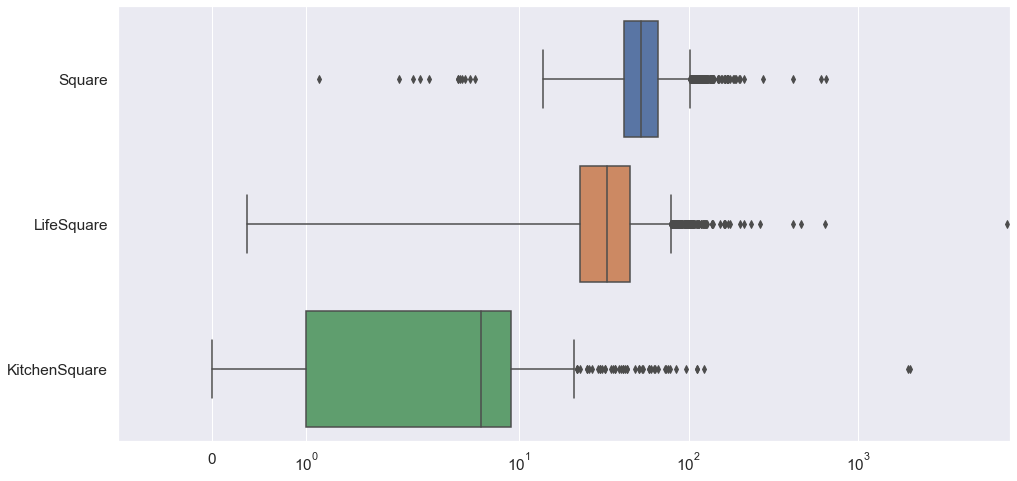

In [38]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

In [39]:
df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(df['Rooms'].median())
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [40]:
# заменим аномальные значения площадей на медианы
df.loc[(df['LifeSquare'] > 70) | ((df['LifeSquare'] < 30)), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[(df['Square'] > 150) | (df['Square'] < 30), 'Square'] = df['Square'].median()
df.loc[(df['KitchenSquare'] > 20) | ((df['KitchenSquare'] < 6)), 'KitchenSquare'] =df['KitchenSquare'].median()
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.177560,38.061529,7.45680,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,17.866327,8.637273,2.04371,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,30.017128,30.008380,6.00000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.046051,32.781260,6.00000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.00000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.820977,42.639332,9.00000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,148.671938,69.974154,20.00000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [41]:
df=df.sort_values(by='Square')
df.LifeSquare.fillna(method='pad',inplace=True)

df=df.sort_values(by='DistrictId')
df.Healthcare_1.fillna(method='pad',inplace=True)

df.sort_index(inplace=True)

In [42]:
# заменим квартиры, расположенные выше последнего этажа на последний этаж
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']

In [43]:
df[df['Floor'] > df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [44]:
df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2022

*************НОВЫЕ ФИЧИ

In [45]:
#добавдение новой фичи - стоимости квадратного метра в зависимости от района и количества комнат
df['Square_metres'] = round(df['Price'] / df['Square'], 2)
df.head()

med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square_metres':'median'})\
                            .rename(columns={'Square_metres':'MedSquare_metres'})

med_price_by_district.head(10)


,DistrictId,Rooms,MedSquare_metres
0,0,1.0,3585.900
1,0,2.0,3697.860
2,0,3.0,4405.320
3,1,1.0,3427.370
4,1,2.0,3205.265
5,1,3.0,3001.165
6,1,4.0,2775.880
7,2,1.0,4765.565
8,2,2.0,4523.860
9,2,3.0,4320.550


In [46]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_metres,MedSquare_metres
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,...,11,3097,0,2672.0,0,0,B,305018.871089,2651.71,2790.800
1,3013,22,1.0,39.832524,32.781260,8.0,7.0,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,4462.05,3680.060
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,3600.60,3001.165
3,2352,1,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,0.007122,...,1,264,0,240.0,0,1,B,168106.007630,4160.02,3427.370
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,33,8667,2,30.0,0,6,B,343995.102962,5351.09,4289.670


In [47]:
#добовим новую фиктивную переменную, показывающую, если квартира находится на 
# первом или последнем этаже (на первом и последнем этажах квартиры стоят дешевле). 
df['Last_floor'] = 0
df.loc[(df['Floor'] == df['HouseFloor']) & (df['Floor'] != 1) , 'Last_floor'] = 1
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_metres,MedSquare_metres,Last_floor
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,...,3097,0,2672.0,0,0,B,305018.871089,2651.71,2790.800,0
1,3013,22,1.0,39.832524,32.781260,8.0,7.0,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,4462.05,3680.060,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,3600.60,3001.165,0
3,2352,1,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,0.007122,...,264,0,240.0,0,1,B,168106.007630,4160.02,3427.370,0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,8667,2,30.0,0,6,B,343995.102962,5351.09,4289.670,1


In [48]:
# видно, что средняя стоимость не на последних этажах действительно выше, чем на первых и последних
df.groupby(["Last_floor"])["Price"].mean()

Last_floor
0    214514.921184
1    212830.802127
Name: Price, dtype: float64

In [49]:
#квартиры на последнем этаже могут быть элитными и стоить дороже, чем на других этажах
df['Penthouse'] = 0
df.loc[(df['Floor'] == df['HouseFloor']) , 'Penthouse'] = df['Square']*df['Last_floor']
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_metres,MedSquare_metres,Last_floor,Penthouse
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,...,0,2672.0,0,0,B,305018.871089,2651.71,2790.800,0,0.000000
1,3013,22,1.0,39.832524,32.781260,8.0,7.0,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,4462.05,3680.060,0,0.000000
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,3600.60,3001.165,0,0.000000
3,2352,1,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,0.007122,...,0,240.0,0,1,B,168106.007630,4160.02,3427.370,0,0.000000
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,30.0,0,6,B,343995.102962,5351.09,4289.670,1,64.285067


In [50]:
#посчитаем возраст дома
year=datetime.now().year
df['H_age'] = year - df['HouseYear']
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_metres,MedSquare_metres,Last_floor,Penthouse,H_age
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,...,2672.0,0,0,B,305018.871089,2651.71,2790.800,0,0.000000,8
1,3013,22,1.0,39.832524,32.781260,8.0,7.0,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,4462.05,3680.060,0,0.000000,56
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,3600.60,3001.165,0,0.000000,34
3,2352,1,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,0.007122,...,240.0,0,1,B,168106.007630,4160.02,3427.370,0,0.000000,45
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,30.0,0,6,B,343995.102962,5351.09,4289.670,1,64.285067,50


In [51]:
#кодируем категориалную переменную "возраст дома"
def age_to_binary_cat(X):
    X['Age_binary_cat'] = 0
    X.loc[X['H_age'] <= 10, 'Age_binary_cat'] = 1
    X.loc[(X['H_age'] > 10) & (X['H_age'] <= 25), 'Age_binary_cat'] = 2
    X.loc[(X['H_age'] > 25) & (X['H_age'] <= 40), 'Age_binary_cat'] = 3
    X.loc[(X['H_age'] > 40) , 'Age_binary_cat'] = 4
    return X

In [52]:
# кодируем экологию
df['Ecology_2_cat'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3_cat'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2_cat'] = df['Shops_2'].replace({'A':0, 'B':1})

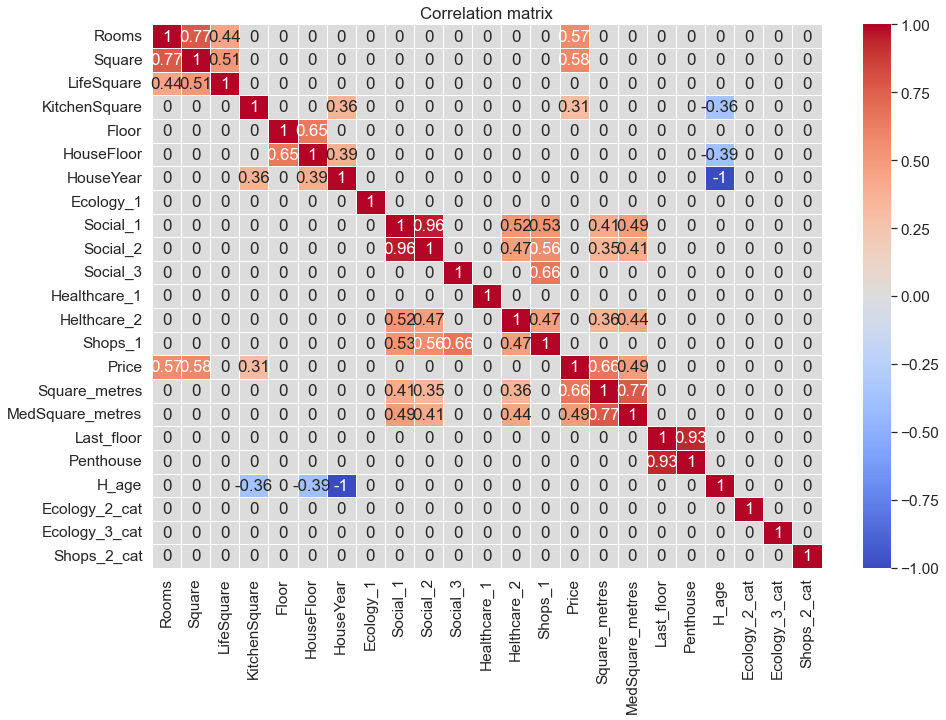

In [53]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [54]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.medians = None
        self.current_year=None
        self.Square_metres = None
        self.Last_floor = None
        self.Penthouse = None
        self.H_age = None
        self.Age_binary_cat = None
        self.med_price_by_district = None
        self.cat_columns=None
        self.sm = None
        
        
    def fit(self, X, y=None): 
        """Сохранение статистик"""
        self.medians = X.median()
        
        #стоимость квадратного метра       
        X.insert(1, 'Square_metres',round(X['Price']/X['Square'],2))
        self.med_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Square_metres':'median'})\
                            .rename(columns={'Square_metres':'MedSquare_metres'})
        X.drop('Square_metres', axis=1, inplace=True)  

        self.sm=df.groupby(by=['Rooms'])['Square_metres'].mean().rename('Sm_rooms', inplace=True)
        
        
    def transform(self, X, y=None):
        
        """Трансформация данных"""
        # 1. Пропуски
        # Healthcare_1
        X=X.sort_values(by='DistrictId')
        X.Healthcare_1.fillna(method='pad',inplace=True)
        
            
        # LifeSquare 
        X=X.sort_values(by='Square')
        X.LifeSquare.fillna(method='pad',inplace=True)
        X.sort_index(inplace=True)       
        X.fillna(self.medians, inplace=True)        
    
        # 2. Выбросы (outliers)
        # Rooms   
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']   
    
       #Square
        X.loc[(X['Square'] > 150) | (X['Square'] < 30), 'Square'] = self.medians['Square']
     
        #LifeSquare
        X.loc[(X['LifeSquare'] > 70) | ((X['LifeSquare'] < 30)), 'LifeSquare'] = self.medians['LifeSquare']
        
        # KitchenSquare
        condition = (X['KitchenSquare'] > 20) | ((X['KitchenSquare'] < 6))
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
                
        # HouseFloor, Floor
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
               
        # HouseYear
        current_year = datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
            
        # 3. Новые фичи (features)
        X = X.merge(self.sm, on=['Rooms'], how='left')
        X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        X.insert(1, 'MedSquare_metres', X.pop('MedSquare_metres'))
        X.info
        
        # Заменяем пропуски, которые получились из-за того, что в тесте и трейне есть несовпадающие по Id районы,
        # на среднюю стоимость кв.м в зависимости от площади
        
        X.MedSquare_metres.fillna(X.Sm_rooms, inplace=True)
        
        # Удаляем лишнее
        
        X.drop('Sm_rooms', axis=1, inplace=True)
        
        

         
        #преобразование к фиктивным переменным экология и магазины
        self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].replace(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].replace(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(self.binary_to_numbers)
        
        #кодируем возраст дома и исключаем его из выборки, чтобы не было мультиколлинеаности
        current_year = datetime.now().year
        X['H_age'] = current_year - X['HouseYear']
        X = self.year_to_cat(X)   # + столбец year_cat
        X.drop('H_age', axis=1, inplace=True)  
        
        #кодируем первые и последние этажи
        X['Last_floor'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']) & (X['Floor'] != 1) , 'Last_floor'] = 1
        
        #кодируем пентхаусы
        X['Penthouse'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']) , 'Penthouse'] = X['Square']*X['Last_floor']
        
        return X
    
     
    def year_to_cat(self, X):
        current_year = datetime.now().year
        X['Age_binary_cat'] = 0
        X.loc[(current_year - X['HouseYear']) <= 10, 'Age_binary_cat'] = 1
        X.loc[((current_year - X['HouseYear']) > 10) & ((current_year - X['HouseYear']) <= 25), 'Age_binary_cat'] = 2
        X.loc[((current_year - X['HouseYear']) > 25) & ((current_year - X['HouseYear']) <= 40), 'Age_binary_cat'] = 3
        X.loc[((current_year - X['HouseYear']) > 40) , 'Age_binary_cat'] = 4
        X['Age_binary_cat'].fillna(-1, inplace=True)
        return X

# Обучаем датасет

In [55]:
generator=FeatureGenerator()
generator.fit(data)
df_pr=generator.transform(data)
X_test=generator.transform(X_test)

In [56]:
#задаем целевую переменную
y_train=df_pr.Price
#исключаем из обучающего маччива целевую переменную
X_train=df_pr.drop(['Id', 'Price'], axis=1)
# Столбец 'Id' из тестовых данных сохраним, он будет нужен для файла с результатом
test_id=X_test.pop('Id')

In [57]:
#проверяем размеры выборок
X_train.shape, X_test.shape, y_train.shape

((10000, 22), (5000, 22), (10000,))

In [72]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
dt_model=GradientBoostingRegressor(learning_rate=0.02, max_depth=5, max_features=0.5, n_estimators=700, random_state=24 )
dt_model.fit(X_train, y_train)
pred=dt_model.predict(X_test)

Wall time: 41.8 s


In [59]:
#оцениваем R^2. он достаточно высокий
dt_model.score(X_train,y_train)

0.8694194513163519

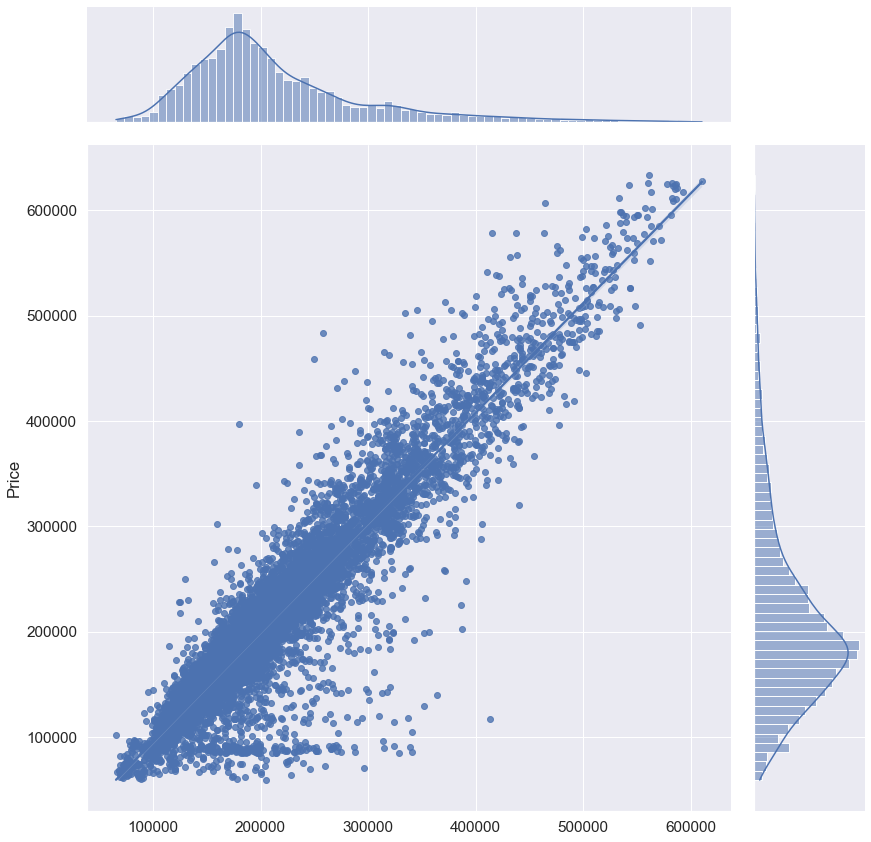

In [61]:
#построим график зависимостей предсказанных значений и фактических
#видно, что они складыаются в прямую, что говорит о том, что теоретические данные неплохо предсказаны
sns.jointplot(x=dt_model.predict(X_train), y=y_train, kind='reg', height=12)
plt.show()

In [62]:
#наибольший вклад в модель делают общая площадь квартиры, стоимость квадратного метра и количество комнат
#искуственно введенная переменная "Стоимость квадратного метра" делает вклад менее 50%, соответственно можно оставить в модели
feature_importances = pd.DataFrame(zip(X_train.columns, dt_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.358933
0,MedSquare_metres,0.277957
2,Rooms,0.131154
13,Social_2,0.052437
12,Social_1,0.028382
14,Social_3,0.026077
8,HouseYear,0.019226
5,KitchenSquare,0.017140
4,LifeSquare,0.016556
7,HouseFloor,0.015330


In [64]:
X_test.shape

(5000, 22)

In [65]:
X_test

,MedSquare_metres,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Age_binary_cat,Last_floor,Penthouse
0,4806.415,44,1.0,36.847630,32.781260,6.0,5.0,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,1,4,0,0.000000
1,2763.145,62,1.0,42.493907,42.568133,10.0,7.0,17.0,2017,0.072158,...,2,629,1,2300.0,0,0,0,1,0,0.000000
2,2579.500,27,2.0,59.463678,39.465914,9.0,19.0,19.0,1977,0.211401,...,9,1892,0,2672.0,0,1,1,4,1,59.463678
3,2105.550,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,2,475,0,0.0,0,0,1,4,1,49.646030
4,3404.240,74,1.0,53.837056,53.772421,6.0,8.0,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,1,4,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4180.800,29,2.0,43.177521,30.339945,6.0,5.0,5.0,1962,0.069660,...,31,6119,4,2729.0,1,2,1,4,1,43.177521
4996,4273.150,38,3.0,93.698122,32.781260,10.0,21.0,27.0,2018,0.060753,...,15,2787,2,520.0,0,7,1,1,0,0.000000
4997,4467.850,101,1.0,33.656723,32.781260,6.0,2.0,5.0,1966,0.038693,...,28,6533,1,1015.0,2,5,1,4,0,0.000000
4998,4747.010,10,1.0,38.635155,32.781260,9.0,8.0,14.0,1970,0.089040,...,33,7976,5,30.0,0,11,1,4,0,0.000000


In [66]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [68]:
#рассчитываем предсказание
predictions = dt_model.predict(X_test)
predictions

array([166454.59403577, 124679.21808076, 144784.77450221, ...,
       144663.03573238, 190180.90265687, 262404.03010335])

In [69]:
#предсказываем цену
submit['Price'] = predictions
submit.tail()

,Id,Price
4995,10379,188376.380176
4996,16138,385843.113932
4997,3912,144663.035732
4998,5722,190180.902657
4999,11004,262404.030103


In [70]:
#сохранение результатов
submit.to_csv('rf_submit.csv', index=False)